#### Par : Bekdouche Lina Insaf 28620402 M2-ISI

# Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage 

In [1105]:
#import librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pypff
from numpy.linalg import inv
# importing random module
import random
%matplotlib inline  

# 1 Préparation des données

## 1.1 Téléchargement des données

In [1106]:
myfile_train_img = open('Data/300w_train_images.txt', 'r')    # open lorem.txt for reading text
contents_train_img = myfile_train_img.read()                             # read the entire file to string

In [1107]:
myfile_train_land = open('Data/300w_train_landmarks.txt', 'r')    # open lorem.txt for reading text
content_train_land = myfile_train_land.read() 

In [1108]:
myfile_test_img = open('Data/helen_testset.txt', 'r')    # open lorem.txt for reading text
contents_test_img = myfile_test_img.read()                

In [1109]:
myfile_test_land = open('Data/helen_testset_landmarks.txt', 'r')    # open lorem.txt for reading text
contents_test_land = myfile_test_land.read()    

In [1110]:
train_images_paths = contents_train_img.split()
train_landmarks_paths = content_train_land.split()
test_images_paths = contents_test_img.split()
test_landmarks_paths = contents_test_land.split()

In [1111]:
len(train_images_paths),len(train_landmarks_paths),len(test_images_paths),len(test_landmarks_paths)

(3148, 3148, 330, 330)

In [1112]:
#upload landmark cordinates
def upload_landmark(landmarks_paths):
    landmarks = []
    for file in landmarks_paths:
        landmark_file = open('Data/'+file, 'r')    # open lorem.txt for reading text
        landmark = landmark_file.read() 
        landmark = landmark.split('\n')
        cordinates=[]
        for cor in range(len(landmark)-1):
            x,y = landmark[cor].split()
            cordinates.append([float(x),float(y)])
        landmarks.append(cordinates)  
    return landmarks

In [1113]:
landmarks_train = upload_landmark(train_landmarks_paths)
landmarks_test = upload_landmark(test_landmarks_paths)

In [1114]:
np.shape(landmarks_train),np.shape(landmarks_test)

((3148, 68, 2), (330, 68, 2))

## 1.2 Visualisation des données

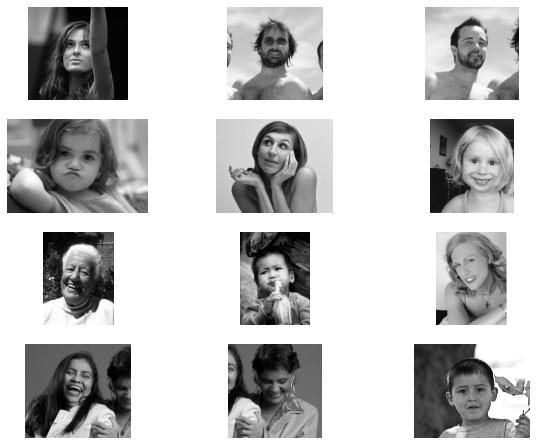

In [1115]:
#visiualiser les photos 
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(5,3,i+1)
    img = cv2.imread('Data/'+train_images[i], 0)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [1116]:
#fonction pour afficher les images avec les landmark correspondant 
def plot_face_with_landmarks(img,landmark):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    for c in landmark :
        plt.scatter(c[0], c[1],c='r',s=2)
    #plt.axis('off')
    plt.show()


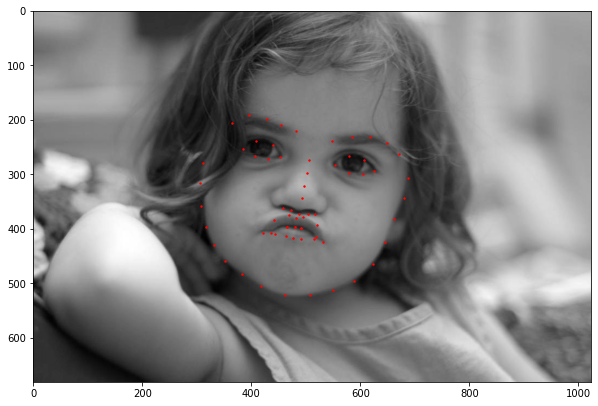

In [1117]:
#test on image 3
img = cv2.imread('Data/'+train_images[3],0)
plot_face_with_landmarks(img,landmarks_train[3])

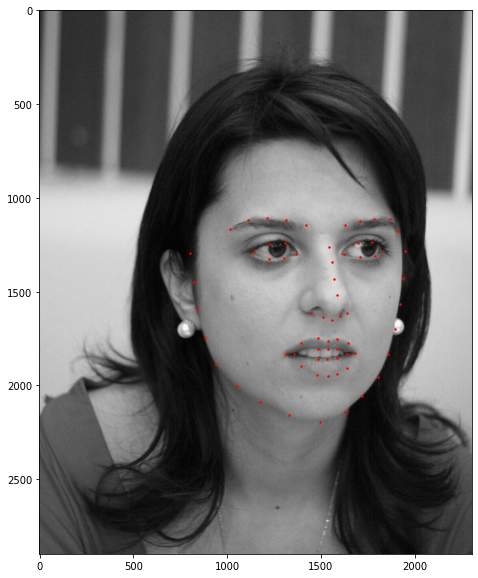

In [1118]:
#image from test set : 
#test on image 3
img = cv2.imread('Data/'+test_images[3],0)
plot_face_with_landmarks(img,landmarks_test[3])

## 1.3 Augmentation des données

### 1 - Calcule des paramètres de la boite englobante des points caractéristiques du visage :

In [1119]:
def get_bounding_box(coordinates):
    b = (int(min([i[0] for i in coordinates])),int(min([i[1] for i in coordinates])))
    d = (int(max([i[0] for i in coordinates])),int(max([i[1] for i in coordinates])))
    x, y = b
    w, h = d[0]-x,d[1]-y
    return x, y, w, h

In [1120]:
def plot_bounding_box(img, x, y, w, h):
    fig = plt.figure(figsize=(10, 10))
    cv2.rectangle(img,(x,y),(x+w,y+h), (0, 255, 0), 2)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [1121]:
x, y, w, h= get_bounding_box(landmarks[3])
x, y, w, h

(306, 190, 381, 331)

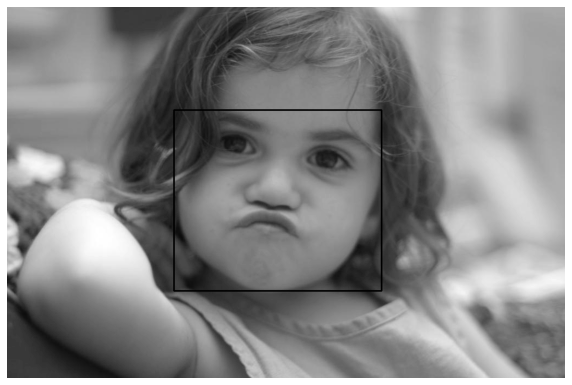

In [1122]:
img = cv2.imread('Data/'+train_images[3], 0)
plot_bounding_box(img,x,y,w,h)

### 2 - Elargir la boîte englobante de 30%, et découper les images avec ces nouvelles dimensions :

In [1123]:
def crop_image(img,x,y,w,h):
    w_ = int(0.3*w)
    h_ = int(0.3*h)
    max_pic_x = img.shape[1]
    max_pic_y = img.shape[0]

    x_min, x_max = x-w_, x+w+w_
    y_min, y_max = y-h_, y+h+h_

    if x - w_ < 0 :
        x_min = 0
    if y - h_ <0 :
        y_min = 0
    if y+h+h_>max_pic_y:
        y_max = max_pic_y
    if x+w+w_>max_pic_x:
        x_max = max_pic_x

    crop_img = img[y_min:y_max, x_min:x_max]
    return crop_img,x_min,y_min
    

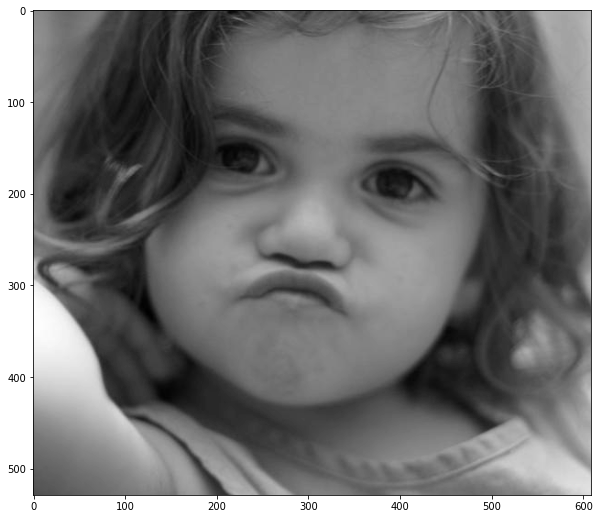

In [1124]:
img = cv2.imread('Data/'+train_images[3], 0)
crop_img,x_min,y_min = crop_image(img,x,y,w,h)
fig = plt.figure(figsize=(10, 10))
plt.imshow(crop_img, cmap='gray')
plt.show()

### 3 - Redimensionnement des images en (128 ∗ 128) :

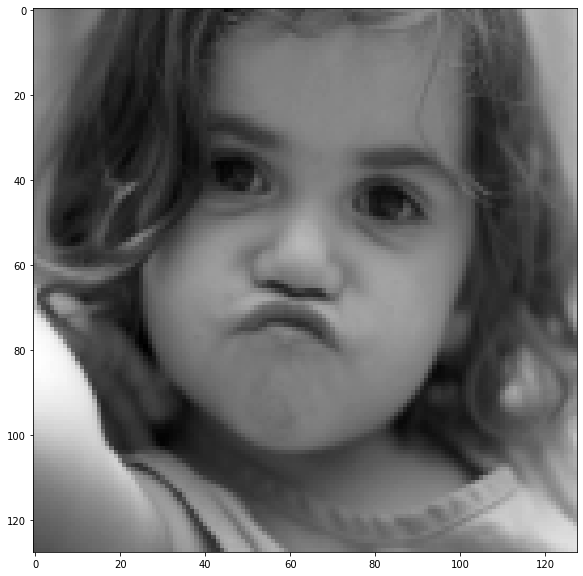

In [1125]:
img_resized = cv2.resize(crop_img, (128,128),interpolation = cv2.INTER_AREA)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_resized, cmap='gray')
#plt.axis('off')
plt.show()

### 4 - Calcule des coordonnées des points caractéristiques pour les nouvelles images : 

In [1126]:
def find_coordinates_after_crop(old_coordinates,x_min,y_min):
    out = []
    for c in old_coordinates:
        out.append( (c[0] - (x_min),
                     c[1] - (y_min)))
    return out

In [1127]:
def find_coordinates_after_reshape(img,old_coord,new_shape=(128,128)):
    old_shape = img.shape
    new_co = []
    for c in old_coord : 
        new_x = (((c[0])*new_shape[0])/old_shape[1])
        new_y = (((c[1])*new_shape[1])/old_shape[0])
        new_co.append([new_x,new_y])
    return new_co

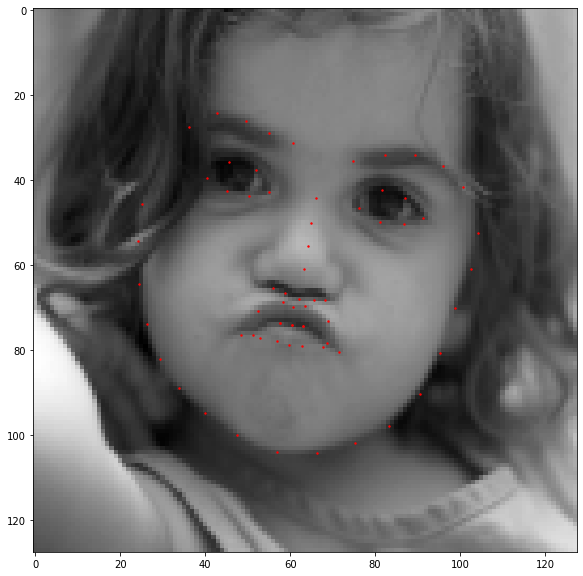

In [1128]:
new_coor =  find_coordinates_after_crop(landmarks[3],x_min,y_min)
new_co = find_coordinates_after_reshape(crop_img,new_coor)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_resized, cmap='gray')
for c in new_co :
    plt.scatter(c[0], c[1],c='r',s=2)
#plt.axis('off')
plt.show()

### 5 - Refaire la meme chose pour un l'ensemble d'image :

In [1129]:
def preprocess_input_data(images, landmarks):
    new_images = []
    new_landmarks =[]
    for i in range(len(images)):
        #find bounding box
        img = cv2.imread('Data/'+images[i], 0)
        x, y, w, h = get_bounding_box(landmarks[i])
        
        #crop image by bbox + 30%
        crop_img,x_min,y_min = crop_image(img,x,y,w,h)
        #calculate landmarks coordinates after the crop
        new_coor =  find_coordinates_after_crop(landmarks[i],x_min,y_min)
        
        # resize to 128*128
        img_resized = cv2.resize(crop_img, (128,128),interpolation = cv2.INTER_AREA)
        #calculate landmarks coordinates after reshape
        new_co = find_coordinates_after_reshape(crop_img,new_coor)
        #save
        new_images.append(img_resized)
        new_landmarks.append(new_co)
        
    return new_images, new_landmarks

In [1130]:
new_train_images,new_train_landmarks = preprocess_input_data(train_images, landmarks_train)

In [1131]:
new_test_images,new_test_landmarks = preprocess_input_data(test_images, landmarks_test)

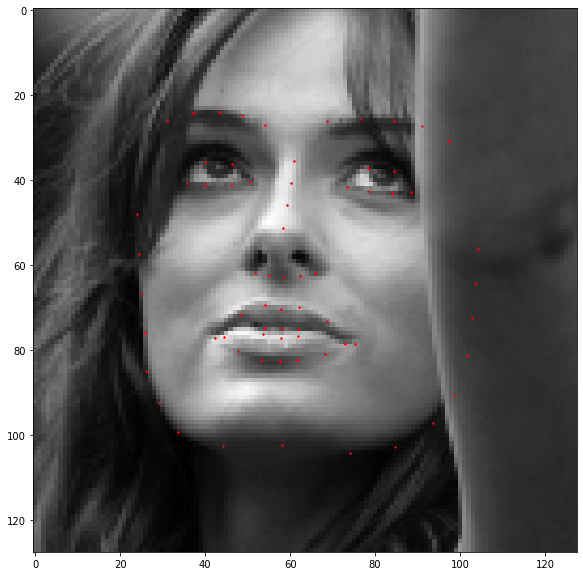

In [1132]:
plot_face_with_landmarks(new_train_images[0],new_train_landmarks[0])

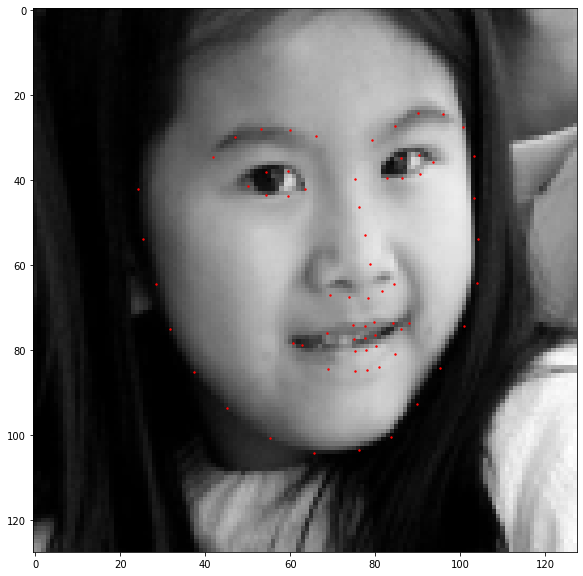

In [1133]:
plot_face_with_landmarks(new_test_images[0],new_test_landmarks[0])

### 6 - Moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage

In [1134]:
mean_cor = []
for c in range(len(new_train_landmarks[0])):
    x_sum = 0
    y_sum = 0
    for i in range(len(new_train_landmarks)):
        x_sum+=new_train_landmarks[i][c][0]
        y_sum+=new_train_landmarks[i][c][1]
    x_mean = x_sum/len(new_train_landmarks)
    y_mean = y_sum/len(new_train_landmarks)
    mean_cor.append([x_mean,y_mean])
    

### 7 - Générer 10 perturbations aléatoires de la position des points caractéristiques

In [1135]:
S0 = np.array(mean_cor)
to_change = random.sample(range(68), 10)
for c in to_change:
    f_e_x = random.sample(range(-20,20), 1)[0]/100 
    f_e_y = random.sample(range(-20,20), 1)[0]/100
    f_t_x = random.sample(range(-20,20), 1)[0]  
    f_t_y = random.sample(range(-20,20), 1)[0] 
    S0[c,0]  =  (1+f_e_x)*S0[c,0] + f_t_x
    S0[c,1]  =  (1+f_e_y)*S0[c,1] + f_t_y  
    
    
S0_tot = np.array([S0 for i in range(len(new_train_images))])

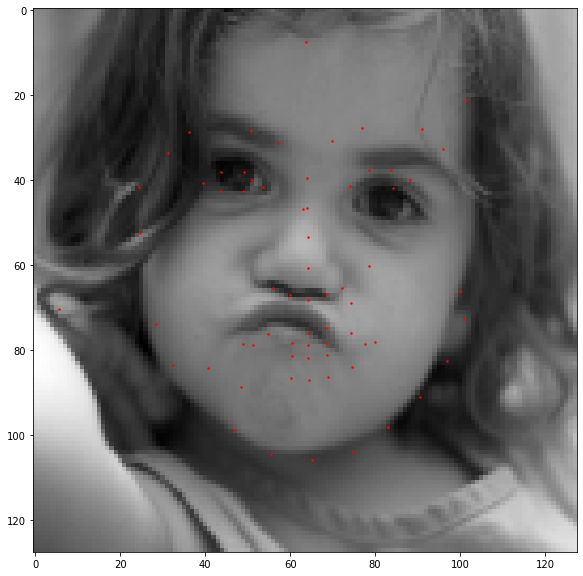

In [1136]:
plot_face_with_landmarks(new_train_images[3],S0_tot[3])

# 2 Apprentissage d’un régresseur simple

##### Reponse 1 :
Ici on essaye de determiner les points caracteristiques du visage, on utilise donc un feature extractor afin d'extraire seulement les caractéristiques locales qui sont calculées autour des points d'intérêt 

## 2.1 Extraction de caractéristiques image

In [1137]:
def convert_toKeypoints(images,S0):
    keypoints = []
    for i in range(len(images)):
        points = []
        for p in S0[i]:
            points.append(cv2.KeyPoint(int(p[0]),int(p[1]),20))
        keypoints.append(points)
    return keypoints

In [1138]:
keypoints_train = convert_toKeypoints(new_train_images,S0_tot)

In [1139]:
def get_sift_descriptors(images,keypoints):
    des = []
    for i in range(len(images)):
        sift = cv2.SIFT_create()
        [key,descriptors] = sift.compute(images[i],keypoints[i])
        descriptor = np.concatenate(descriptors)
        des.append(descriptor)
    return des

In [1140]:
des = get_sift_descriptors(new_train_images,keypoints_train)

##### Reponse question 5:
Autres algorithmes qu'on pouvait utiliser : 
- Speed up robust feature (SURF)
- oriented FAST,rotated BRIEF (ORB)

## 2.2 Réduction de dimensionalité

##### Réponse question 1 :

La réduction de dimensionnalité en machine learning réduit énormément  le temps de calcul mais aussi nous permet d'avoir un algorithme plus robuste vu que nos données seront plus légères et moins complexes. 

Les principales méthodes de réduction de dimensionalité :
- PCA (Principal Component Analysis)
- LDA (Linear Discriminant Analysis)

In [1141]:
from sklearn.decomposition import PCA

In [1142]:
pca = PCA(n_components=0.98)
pca.fit(des)

PCA(n_components=0.98)

In [1143]:
sum(pca.explained_variance_ratio_)

0.9800736072702213

In [1144]:
X0 = pca.transform(des)
X0.shape

(3148, 232)

## 2.3 Estimation du déplacement

In [1145]:
def deplacement_optimal(landmarks,points):
    d=[]
    for j in range(len(landmarks)):
        dep_opt = []
        for i in range(len(S0_tot[0])):
            X = landmarks[j][i][0]-points[j][i][0]
            Y = landmarks[j][i][1]-points[j][i][1]
            dep_opt.append([X,Y])
        d.append(np.reshape(dep_opt,(136)))
    return d

In [1146]:
#calcul de la matrice Y0
Y0 = np.c_[X0,np.ones(X0.shape[0])]
Y0.shape

(3148, 233)

In [1147]:
#calcul du deplacement optimal
d_o = deplacement_optimal(new_train_landmarks,S0_tot)
d_o = np.array(d_o)
d_o.shape

(3148, 136)

In [1148]:
#calcul de la matrice R
T = Y0.transpose()
T0 = inv(T.dot(Y0))
T1 = T.dot(d_o)
R = T0.dot(T1)
R.shape

(233, 136)

In [1149]:
#Calcul du deplacement ds
ds = Y0.dot(R)
ds.shape

(3148, 136)

In [1150]:
#calcul de l'erreur
e = d - ds
e.shape

(3148, 136)

In [1151]:
#calcul de la position des points finale
ds = np.reshape(ds,(len(ds),68,2))
S_finale = S0_tot + ds

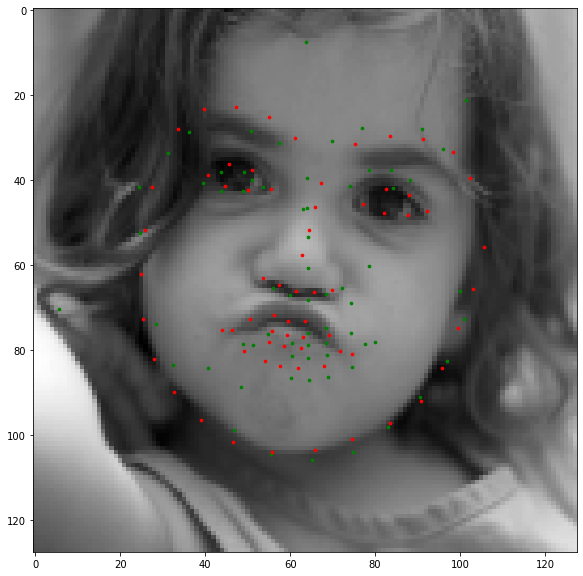

In [1152]:
#affichage des points de departs et des points finaux 
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_train_images[3], cmap='gray')
for c in S0_tot[3]:
    plt.scatter(c[0], c[1],c='g',s=7)
    
for c in S_finale[3]:
    plt.scatter(c[0], c[1],c='r',s=7)
#plt.axis('off')
plt.show()

Points de depart S0 en vert et les points finaux en rouge

## 2.4 Validation sur un ensemble de test externe

##### Reponse question 1 : 
L’évaluation précédente n’est-elle pas pertinente pour évaluer la capacité de généralisation de la procédure d’alignement de points caractéristiques car le calcul les matrices R et A s'est fait à partir des images de train, donc l'évaluation sur ce set là ne peut etre generalise vu que forcément on aura des bon résultats. Donc afin de voir si notre modèle de régression est généralisable on doit le tester sur un ensemble externe. 

In [1153]:
def predict_regresseur(images,points_init,R,A) : 
    keypoints = convert_toKeypoints(images,points_init)
    des = get_sift_descriptors(images,keypoints)
    X0 = A.transform(des)
    Y0 = np.c_[X0,np.ones(X0.shape[0])]
    deplacement = Y0.dot(R)
    deplacement = np.reshape(deplacement,(len(deplacement),68,2))
    points_fin = points_init[:len(images)] + deplacement
    return points_fin, deplacement

In [1154]:
#predir le deplacement pour test set
S0_fin_test,deplacement_test =  predict_regresseur(new_test_images,S0_tot,R,pca)

In [1155]:
#calcul du deplacement optimal de test 
d_opt_test = deplacement_optimal(new_test_landmarks,S0_tot)
d_opt_test = np.array(d_opt_test)
d_opt_test.shape

(330, 136)

In [1156]:
#calcul de l'erreur pour le test set
e_test = d_opt_test - np.reshape(deplacement_test,(len(deplacement_test),136))
e_test.shape

(330, 136)

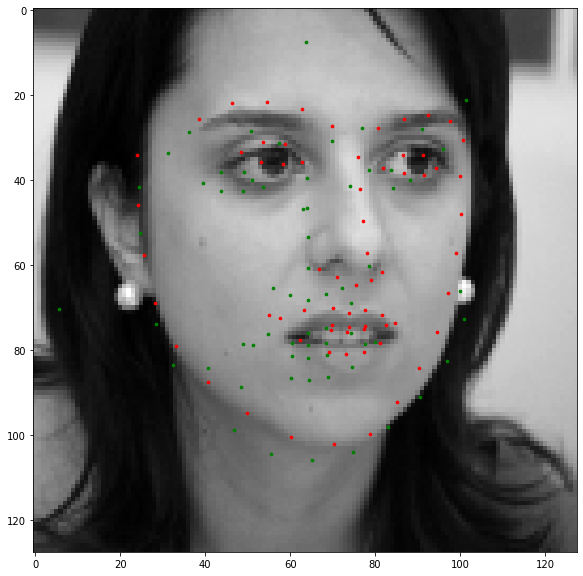

In [1157]:
#affichage des points de departs et des points finaux pour une image dans test

fig = plt.figure(figsize=(10, 10))
plt.imshow(new_test_images[3], cmap='gray')
for c in S0_tot[3] :
    plt.scatter(c[0], c[1],c='g',s=7)
    
for c in S0_fin_test[3]:
    plt.scatter(c[0], c[1],c='r',s=7)
#plt.axis('off')
plt.show()

- Points de depart S0 en vert et les points finaux en rouge
- On remarque que nos points s'alligne quand même sur le visage. Mais c'est pas encore parfait 

# 3 Bonus : Cascade de régresseurs

## 3.1 Itération du processus d’alignement

In [1158]:
def  majPoints(sk, dk):
    dk = np.reshape(dk,(len(dk),68,2))
    sk_ = sk + dk
    return sk_

In [1159]:
def oneStepAlignment(train_images,train_landmarks, points_init):
    # get KeyPoints
    keypoints = convert_toKeypoints(train_images,points_init)
    
    #extraction de caractéristiques image
    des_sift = get_sift_descriptors(train_images,keypoints)

    #Réduction de dimensionalité
    pca = PCA(n_components=0.98)
    pca.fit(des_sift)
    X0 = pca.transform(des_sift)
    
    #calcul deplacement optimal 
    d = deplacement_optimal(train_landmarks,points_init)
    
    #Estimation du déplacement
    Y0 = np.c_[X0,np.ones(X0.shape[0])]
    T = Y0.transpose()
    T0 = inv(T.dot(Y0))
    T1 = T.dot(d)
    R = T0.dot(T1)
    deplacement = Y0.dot(R)
    
    #update points position
    points_final = majPoints(points_init, deplacement)
    
    return points_final, pca, R

In [1160]:
S_f, A, R = oneStepAlignment(new_train_images,new_train_landmarks, S0_tot)

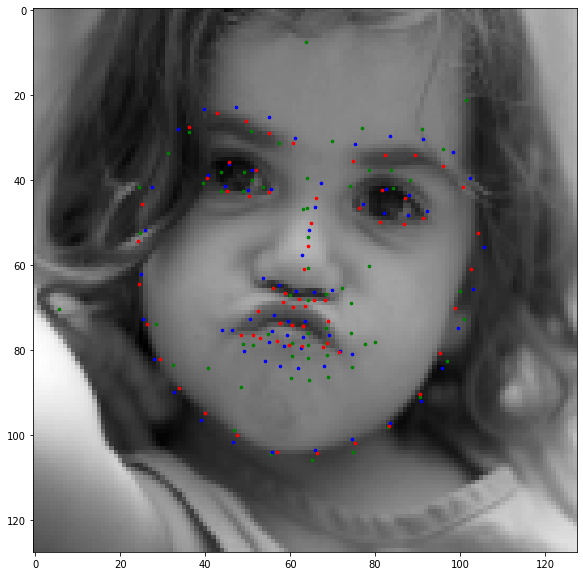

In [1171]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_train_images[3], cmap='gray')
for c in S0_tot[3]:
    plt.scatter(c[0], c[1],c='g',s=7)
    
for c in S_f[3]:
    plt.scatter(c[0], c[1],c='b',s=7)
    
for c in new_train_landmarks[3]:
    plt.scatter(c[0], c[1],c='r',s=7)
#plt.axis('off')
plt.show()

- en vert la position des points initiale 
- En bleu la position des point aprés une seule itération d'alignement
- En rouge la position optimal des points
##### Commentaire : 

On voit que notre alignement apres une seule iteration n'est pas encore proche de la realité même si les resultats sont tout de même bien. On va donc essayer d'iterer le process pour voir si on peut apprendre d'avantage. 


In [1162]:
k = 5
current_points = S0_tot
sk, Ak, Rk = [], [], []
for i in range(k):
    print("iteration number : ",i)
    next_points, A, R = oneStepAlignment(new_train_images,new_train_landmarks,current_points)
    sk.append(next_points)
    Ak.append(A)
    Rk.append(R)
    current_points = next_points

iteration number :  0
iteration number :  1
iteration number :  2
iteration number :  3
iteration number :  4


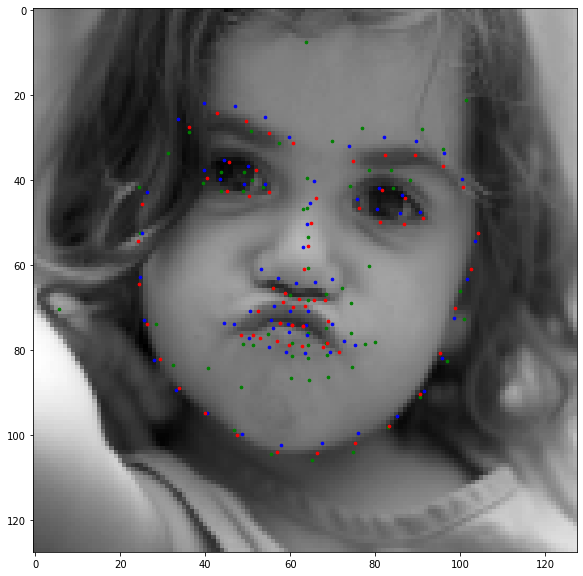

In [1170]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_train_images[3], cmap='gray')
for c in S0_tot[3]:
    plt.scatter(c[0], c[1],c='g',s=7)
    
for c in sk[4][3]:
    plt.scatter(c[0], c[1],c='b',s=7)
    
for c in new_train_landmarks[3]:
    plt.scatter(c[0], c[1],c='r',s=7)
#plt.axis('off')
plt.show()

- en vert la position des points initiale 
- En bleu la position des point aprés une 5 itération d'alignement
- En rouge la position optimal des points

In [1214]:
def cascade_regression_prediction(images,k,init_points,R,A):
    current_points = init_points
    sk = []
    for i in range(k):
        print("iteration number : ",i)
        next_points,deplacement = predict_regresseur(images,current_points,Rk[i],Ak[i])
        sk.append(next_points)
        current_points = next_points
    return sk

In [1215]:
s_test_k = cascade_regression_prediction(new_test_images,5,S0_tot,Rk,Ak)

iteration number :  0
iteration number :  1
iteration number :  2
iteration number :  3
iteration number :  4


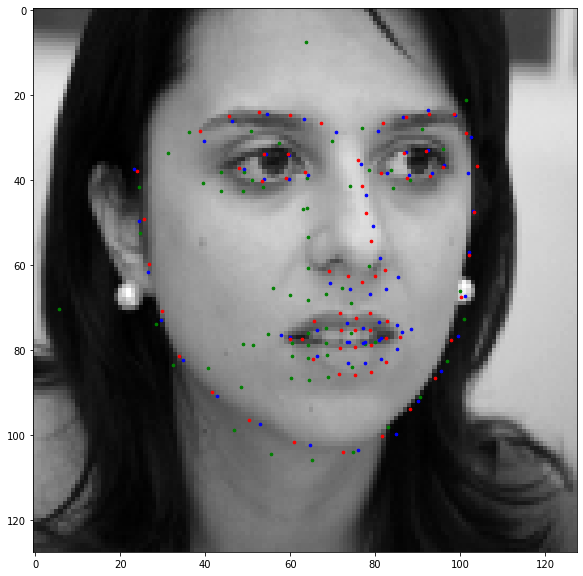

In [1216]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_test_images[3], cmap='gray')
for c in S0_tot[3] :
    plt.scatter(c[0], c[1],c='g',s=7)
    
for c in s_test_k[4][3]:
    plt.scatter(c[0], c[1],c='b',s=7)
    
for c in new_test_landmarks[3]:
    plt.scatter(c[0], c[1],c='r',s=7)
#plt.axis('off')
plt.show()

- en vert la position des points initiale 
- En bleu la position des point aprés une 5 itération d'alignement
- En rouge la position optimal des points

## 3.2 Detection des points caractéristiques sur d’autres images

On a pris une image d'internet et on a tester notre modeles afin de detecter les traits du visage 

In [1172]:
import numpy as np
import cv2
def head_extractor(img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    face = []
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 1)
    for (x,y,w,h) in faces:
        face.append(img[y:y+h,x:x+w])
   
    return face

In [1226]:
img = cv2.imread('./test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [1227]:
face = eye_head_extractor(img)
face = cv2.resize(face[0], (128,128),interpolation = cv2.INTER_AREA)


In [1228]:
sk = cascade_regression_prediction([face],5,S0_tot,Rk,Ak)

iteration number :  0
iteration number :  1
iteration number :  2
iteration number :  3
iteration number :  4


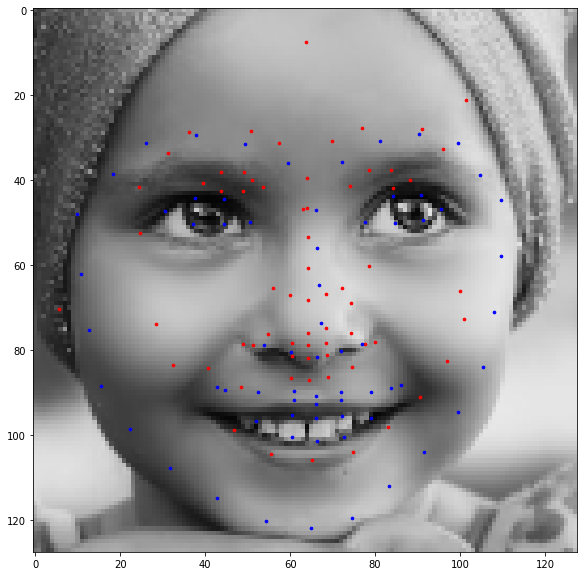

In [1229]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(face, cmap='gray')
for c in S0_tot[0] :
    plt.scatter(c[0], c[1],c='r',s=7)
    
for c in sk[4][0]:
    plt.scatter(c[0], c[1],c='b',s=7)
#plt.axis('off')
plt.show()


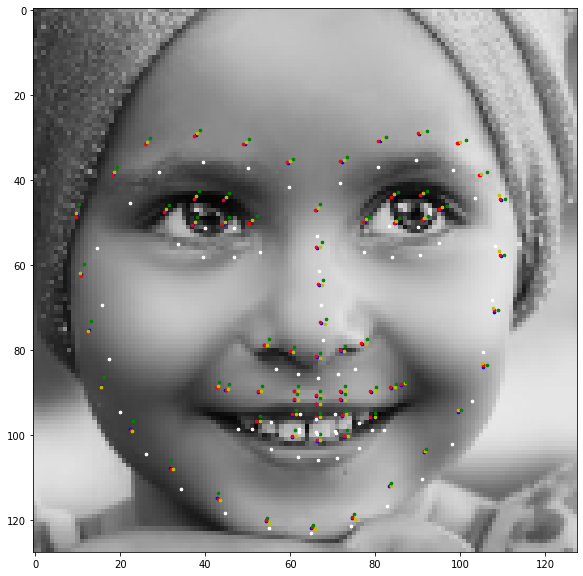

In [1230]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(face, cmap='gray')
for c in sk[4][0]:
    plt.scatter(c[0], c[1],c='b',s=7)
for c in sk[3][0]:
    plt.scatter(c[0], c[1],c='r',s=7)
for c in sk[2][0]:
    plt.scatter(c[0], c[1],c='y',s=7)
for c in sk[1][0]:
    plt.scatter(c[0], c[1],c='g',s=7)
for c in sk[0][0]:
    plt.scatter(c[0], c[1],c='w',s=7)

In [1224]:
img = cv2.imread('./test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = eye_head_extractor(img)
face = cv2.resize(face[0], (128,128),interpolation = cv2.INTER_AREA)

In [1208]:
sk = cascade_regression_prediction([face],5,S0_tot)

iteration number :  0
iteration number :  1
iteration number :  2
iteration number :  3
iteration number :  4


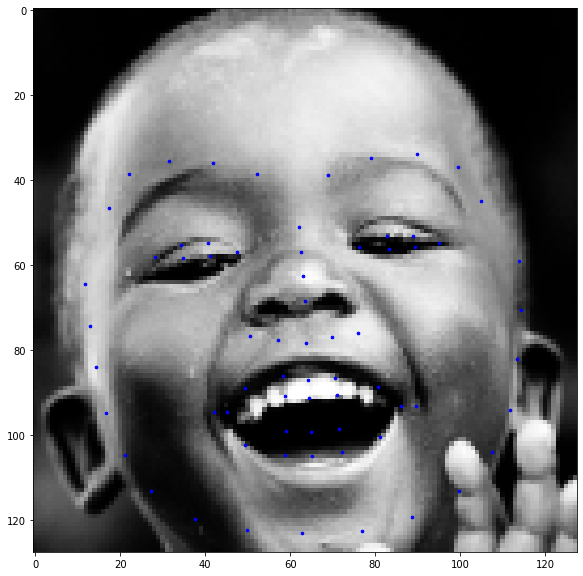

In [1217]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(face, cmap='gray')
for c in sk[4][0]:
    plt.scatter(c[0], c[1],c='b',s=7)